# High Performance Programming CA Part A 2021/22
Gabor Sebestyen - L00170162

# 01. GPU Accelerate a Function

In [1]:
# This allows us to plot right here in the notebook
%matplotlib inline

In [2]:
# Importing pyplot to be able to creates a figure, plotting area, plots lines etc
from matplotlib import pyplot as plt
# Other required imports troughout the CA
import numpy as np
import numba
from numba import vectorize, cuda, jit
import math
from math import hypot
from numpy import testing

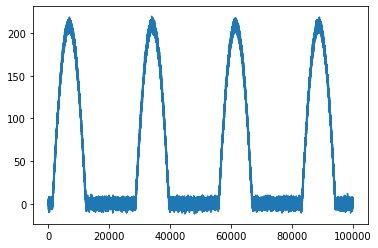

In [3]:
n = 100_000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
waveform = ((pulses * 300) + noise).astype(np.int16)
plt.plot(waveform)

## a) The task was to decorate the zero_supress function to run as vectorized unfunc. 
To allow this the @vectorize function decorator had to be utilized. The original description stated that this function is a GPU accelerated one, therefore signature had to be added to this decorator and the target device had stated. The signature also had to state the output file type (int16) and the input file types (int16, int16). To utilize GPU our target is cuda.

In [4]:
# vectorize with appropriate decorators for input output and target
@vectorize(['int16(int16, int16)'], target='cuda')
def zero_suppress(waveform_value, threshold):
  # Mapping all samples of waveform below a certain magnitude to zero
  if waveform_value < threshold:
    result = 0
  else:
    result = waveform_value
  return result

## b) Plotting the waveform.

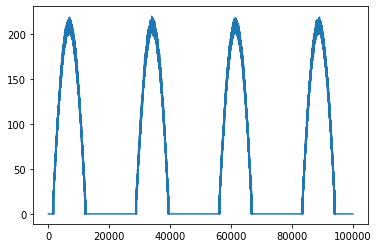

In [5]:
plt.plot(zero_suppress(waveform, 15))

-----------------------------------------------------------------------------

# 02. Optimize Memory Movement

## Cell A

In [6]:
@vectorize(['float32(float32, float32)'], target='cuda')
def add_ufunc(x, y):
  return x + y

## Cell B

In [7]:
@vectorize(['float32(float32, float32, float32)'], target='cuda')
def make_pulses(i, period, amplitude):
  return max(math.sin(i / period) - 0.3, 0.0) * amplitude

## Cell C

In [8]:
n = 100-000
noise = (np.random.normal(size=n) * 3).astype(np.float32)
t = np.arange(n, dtype=np.float32)
period = n / 23

## Original Cell D below

In [9]:
# Original Cell D
# pulses = make_pulses(t, period, 100.0)
# waveform = add_ufunc(pulses, noise)

## Updated Cell D below

In [10]:
# Updated Cell D
# Copying host data to the GPU
pulses = cuda.to_device(make_pulses(t, period, 100.0))
# Creating output array
waveform = cuda.device_array(shape=(n,), dtype=np.float32)
# Calling add_ufunc specifying output buffer with "out" keyword
add_ufunc(pulses, noise, out=waveform)
# Bringing device array back to host
out_host = waveform.copy_to_host()

## a) What code had to be added?
Code had to be added to copy host data to GPU and also needed to transfer this back to the host.

## b) Description of the updated Cell D
The first step was to copy the host data to the GPU using the cuda.to_device. The next step was to create an output array which is the waveform that we aim to plot. This way the add_func function will be faster as its operation will not involve data transfer between the host and the device. To copy back the host after we called add_unfunc copy_to_host() function to the created output array (John, 2022).

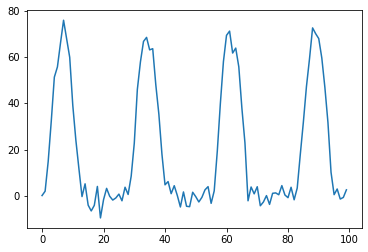

In [11]:
plt.plot(waveform)

-----------------------------------------------------------------------------

# 03 Accelerate a CPU Function as a Custom CUDA Kernel

An out array had to be utilized as a parameter for the function as the CUDA written kernels with @cuda.jit decorator do not have return values. Also, for this reason the content of the definition had to be modified with removing the return statement and assigning the returned value to the out array (John, 2022).

## I. Refactoring square_device function.

### Original square_device function

In [12]:
# def square_device(a):
#   return a**2

### Refactored square_device function

In [13]:
@cuda.jit
def square_device(a, out):
  # Calculating unique thread indexes
  idx = cuda.grid(1)

  # Thread working through elements with same indz as its own
  out[idx] = a[idx]**2

### Below cell with constant values.

In [14]:
n = 4096

a = np.arange(n)
out = a**2  # this variable is only for testing purposes

## II - IV Refactoring of d_a and d_out arrays, modifying blocks and threads, refactoring square_device call.

### Original Cell

In [15]:
# d_a = a
# d_out = np.zeros_like(a)

# blocks = 0
# threads = 0

# d_out = square_device(d_a)

### Cell after modifications and refactoring.

In [16]:
# Creating device array (and host to GPU)
d_a = cuda.to_device(a)
# Creating output array
d_out = cuda.device_array_like(d_a)

# Had to define thread and block size to have a thread to one data element mapping
# Due to the pre-defined kernel of 4096 they were defined as below.(32x128=4096)
blocks = 32
threads = 128

# square_device is launched as kernel with the appropriate settings
square_device[blocks, threads](d_a, d_out)
# Making CPU wait for any pending GPU activity
cuda.synchronize()

In [17]:
testing.assert_almost_equal(d_out, out)

## a) The implementations between I-IV

- @cuda.jit decorator was applied to square_device function and necessary refactoring was made:
Out array was added to signature of the function and calculation for unique thread index has been implemented.
- Host data was sent to GPU and a host data like output array was created.
- Block and threads were modified accordingly for the size of kernel(n).
- square_device was launched as a kernel with the necessary execution configurations.

## b) Outlining the necesserity of the particular changes.

- The @cuda.jit decorator had to be utilized. As kernels written with these decorators have no return values, a signature of the function was modified to get an appropriate type of output array utilized. The thread indexes were then calculated to ensure each thread is engaged with a unique task. After this the appropriate work was conducted by utilizing the thread indexes.
-	In an aim to minimalize the data transfer between the host and device he hosts data was sent to the GPU(d_a) and a host data like output array was created.
-	As per the previous kernel settings(n=4096) 1 thread to 1 data element mapping is required. The number of threads in the grid must be equal to n and was set accordingly. Therefore, blocks may be equal to 32 and threads to 128. 128 x 32 = 4096
-	The square_device fuction call was modified to launch as kernel. The distribution of blocks and threads were assigned and the necessary parameters were added.


-----------------------------------------------------------------------------

# 04 Implement a Grid Stride Loop

## A. Refactoring

### a) The necessary code added

I utilized the @cuda.jit function decorator to comply the function for a non-element wise and vectorized GPU. Assigned the absolute position of the current grid to the start variable. 
The total number of grids (one dimensional thread grid) as highlighted in the
brackets has been calculated and assigned to the stride variable.
Within the for loop all data elements shall be worked on without having to
stepped out of the bounds of the data (John, 2022).

In [18]:
@cuda.jit
def hypot_stride(a, b, c):
  # Calculating unique thread indexes
  start = cuda.grid(1)
  # Calculating total number of threads within entire grid
  stride = cuda.gridsize(1)

  # Thread is working through data elements starting with matching indexes
  # striding number of threads in grid with each iteration while staying
  # within data boundries.
  for i in range(start, a.shape[0], stride):
    c[i] = hypot(a[i], b[i])

The below cell was not required to be changed.





In [19]:
n = 1000000
a = np.random.uniform(-12, 12, n).astype(np.float32)
b = np.random.uniform(-12, 12, n).astype(np.float32)
d_a = cuda.to_device(a)
d_b = cuda.to_device(b)
d_c = cuda.device_array_like(d_b)

blocks = 128

threads_per_block = 64

hypot_stride[blocks, threads_per_block](d_a, d_b, d_c)

In [20]:
testing.assert_almost_equal(np.hypot(a,b), d_c.copy_to_host(), decimal=5)

======

## B. Timing

#### I. A CPU baseline using the regular NumPy np.hypot function

In [21]:
def hypot(x, y):
  return math.sqrt(x*x + y*y)

b) The only single line code that needed to time the non-optimized NumPy function was to utilize the timeit function and call the hypot function with np.hypot with the appropriate parameters.

In [22]:
%timeit np.hypot(3.0, 4.0)

The slowest run took 8.04 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 2.13 µs per loop


#### II. Optimized by Numba hypot function for the CPU.

In [23]:
@vectorize
def hypot(x, y):
  return math.sqrt(x*x + y*y)

c) The multiple lines that were created to time the CPU optimized hypot function using Numba were the @vectorize decorator, which allowed us to use Numba for the CPU and the timeit function what we have used also at the previous example.

In [24]:
%timeit np.hypot(3.0, 4.0)

The slowest run took 6.85 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 2.36 µs per loop


##### Conclusion

The optimized version of the hypot function was showing 75% faster performance(1.04µs) as the baseline model(1.82µs).

#### III. Single threaded CUDA kernel hypot_stride

In [25]:
cuda.synchronize()
%timeit hypot_stride[4096, 1](d_a, d_b, d_c)

1000 loops, best of 5: 6.11 ms per loop


#### IV. Parallel, multiple threaded NumPy function hypot_stride

In [26]:
cuda.synchronize()
%timeit hypot_stride[blocks, threads_per_block](d_a, d_b, d_c)

1000 loops, best of 5: 284 µs per loop


##### Conclusion

- The task description highlighted the mindful being of the cuda.synchronize() function. Calling the function would pause CPU activity until any pending GPU activity is present. 
- The first hypot_stride function call with the single thread would not benefit from this call however, as there was only a single thread present (also for this reason I had to set the number of blocks to 4096 to get the set kernel of 4096 with the multiplication of the blocks and threads). Single thread operations are however automatically serialized (Robert, n.d.).
- The second call for the hypot_stride function with 64 threads could benefit from the cuda.synchronize function call right before the timing. The result makes it very obvious as it was 16 times faster then the single threaded call.

------------------------------------------------------------

# 05 Accelerate Neural Network Calculations

Cell A

In [27]:
import numpy as np
from numba import cuda, vectorize

n = 100000000

greyscales = np.floor(np.random.uniform(0, 255, n).astype(np.float32))
weights = np.random.normal(.5, .1, n).astype(np.float32)

Cell B

In [28]:
from numpy import exp
import math

Cell C

In [29]:
# Utilized vectorize ufuncs at each given functions and
# to run them on GPU for calls and the appropriate decorators
# for input, output and target were given
@vectorize(['float32(float32)'], target='cuda')
def normalize(greyscales):
  return greyscales / 255

@vectorize(['float32(float32, float32)'], target='cuda')
def weigh(values, weights):
  return values * weights

@vectorize(['float32(float32)'], target='cuda')
def activate(values):
  return math.exp((values) - (-values) / (values) + (-values))

Cell D

In [30]:
def create_hidden_layer(greyscales, weights, exp, normalize, weigh, activate):
  # Creating device arrays (copying host data to the GPU)
  normalized = cuda.to_device(normalize(greyscales))
  weighted = cuda.to_device(weigh(normalized, weights))
  activated = cuda.to_device(activate(weighted))

  # Bringing device array back to host for our output
  return activated.copy_to_host()

Cell E

In [31]:
arguments = {"greyscales": greyscales,
             "weights": weights,
             "exp": exp,
             "normalize": normalize,
             "weigh": weigh,
             "activate": activate}

Cell F

In [32]:
a = create_hidden_layer(**arguments)
print(a)

[2.7182817 2.7182815 2.7182817 ... 2.7182817 2.7182817 2.7182815]


## a) The code what had to be added to fulfill the tasks

- Cell A: By instruction this cell did not need any modification, only to change the number of neurons from 1_000_000 to 100_000_000 when all other tasks were successfully finished.
- Cell B: The "import math" line was necessary.
- Cell C: The @vectorize ufuncs decorators were added to the listed functions along with their necessary signatures. The activate function was modified from utilizing the np.exp to the math.exp.
- Cell D: The fuction calls received a cuda.device function call and the return utilized the copy.host() function call.
- Cell E: Did not require any modification.
- Cell F: Did not require any modification.


## b) Description of the modifications

- Cell A: The number of neutrons(n) was modified from 1000000 to 100000000 as per requirement.
-	Cell B: Had to import math for the modification of Cell C, where the math.exp was utilized.
-	Cell C: To allow the 3 functions to run on GPU the generation of an ufunc was required that uses CUDA. Here I utilized the @vectorize decorator what had to be given explicit type signature (input and output data types) and also the target attribute had to be set what was "cuda". There was an additional modification to be done in the activate function, where the np.exp was utilized for return. However due to incapability with the noPython mode the math.exp had to be utilized.
-	Cell D: To optimize the data transfer the host data was copied to the GPU using the cuda.to_device at each line. This way the create_hidden_layer function will be faster as its operation will not involve data transfer between the host and the device. To copy back the host after we called create_hidden_layer function the activated.copy_to_host() was returned.
-	Cell E: Did not require any modification.
-	Cell F: Did not require any modification.


-----------------------------------------------------------------------------

# 06. Accelerated Histogramming Kernel

Cell A

In [33]:
def cpu_histogram(x, xmin, xmax, histogram_out):

  nbins = histogram_out.shape[0]
  bin_width = (xmax - xmin) / nbins

  for element in x:
    bin_number = np.int32((element - xmin) / bin_width)
    if bin_number >= 0 and bin_number < histogram_out.shape[0]:
      # only increment if in range
      histogram_out[bin_number] += 1

Cell B

In [34]:
x = np.random.normal(size=10000, loc=0, scale=1).astype(np.float32)
xmin = np.float32(-4.0)
xmax = np.float32(4.0)
histogram_out = np.zeros(shape=10, dtype=np.int32)

cpu_histogram(x, xmin, xmax, histogram_out)

histogram_out

array([   9,   70,  479, 1601, 2950, 2800, 1524,  481,   80,    5],
      dtype=int32)

Cell C

In [35]:
@numba.jit(nopython=True)
def compute_bin(x, n, xmin, xmax):
    # if x is equal with xmax the return value is the number of bins minus one.
    if x == xmax:
        return n - 1 # a_max always in last bin

    # Calculating the bin_number is x is not equal with xmax.
    bin = np.int32(n * (np.float64(x) - np.float64(xmin)) / (np.float64(xmax) - np.float64(xmin)))

    # Returning null if the bin_number is below 0 or higher or equal with the
    # number of bins.
    if bin < 0 or bin >= n:
        return None
    # If above not true the calculated bin_number is returned.
    else:
        return bin
# (GitHub, 2022)

@cuda.jit
def cuda_histogram(x, xmin, xmax, histogram_out):

    # No explicit bin number is necessary as it will be determined by histogram_out.
    nbins = histogram_out.shape[0]
    bin_width = (xmax - xmin) / nbins

    # Absolute position of the current grid
    start = cuda.grid(1)
    # Total number of grids is calculated
    stride = cuda.gridsize(1)

    # All data elements are worked on.
    for i in range(start, x.shape[0], stride):

        # Calculation of the current bin number.
        bin_number = compute_bin(x[i], nbins, xmin, xmax)

        # If bin number is within appropriate range increment bin number in histogram_out.
        if bin_number >= 0 and bin_number < histogram_out.shape[0]:
          cuda.atomic.add(histogram_out, bin_number, 1)
            
  

### Implementation

- The main task was to increment the bin counts in histogram_out, given the range of xmin, xmax. My initial approach was to implement a single cuda_histogram function. At the first couple of lines in the cuda_histogram function I allowed the determination of the nbins with the size of the histogram_out, which is our target/"out" array. I assigned the absolute position of the current grid to the start variable. The total number of grids (one dimensional thread grid) as highlighted in the brackets has been calculated and assigned to the stride variable. Within the for loop all data elements shall be worked on without having to stepped out of the bounds of the data (John, 2022). Also, before utilizing the add atomic operation had to make sure that the bin_number is within 0 and the shape of the histogram_out.
After running the assortation an error was thrown that required the import of traceback and highlighted only 10% match between the 2 arrays compared.
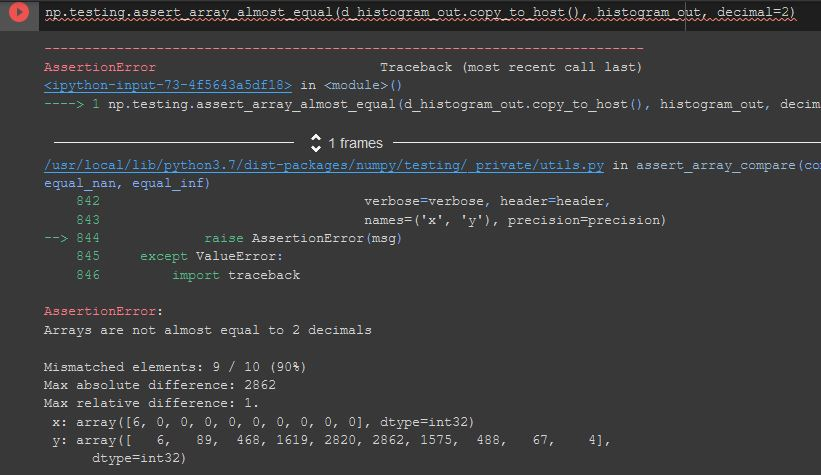
- After detailed research I foud explanation and was pointed out that some calculation of the bin numbers is required prior the incrementation of the bin counts in histogram out. I have implemented the outlined compute_bin function. This function is to return an appropriate bin_number for the final atomic incrementation in the cuda_histogram function. The compute_bin function is called at every iteration in the cuda_histogram. This function is checking first if the current x value in the iteration in cuda_histogram is equal with xmax, if so would return the value for bin_numbers as the number of bins minus 1. If it is less than xmax a calculation would be made for the correct bin_number. If the value of this calculation is below 0 or higher than the number of bins there would be no value to return, else the calculated value would be returned and assigned to bin_numbers in the cuda_histogram function (GitHub, 2022).

Cell D

In [36]:
d_x = cuda.to_device(x)
d_histogram_out = cuda.to_device(np.zeros(shape=10, dtype=np.int32))

blocks = 128
threads_per_block = 64

cuda_histogram[blocks, threads_per_block](d_x, xmin, xmax, d_histogram_out)

Cell E

In [37]:
np.testing.assert_array_almost_equal(d_histogram_out.copy_to_host(), histogram_out, decimal=2)

-----------------------------------------------------------------------------

# 07. Definitions & Terms

## a) Explain what is meant by in CUDA by ‘memory coalescing’ and describe with the aid of several diagrams, how that is achieved.

Memory coalescing means that a single transaction has multiple memory accesses. However some conditions can result in an uncoalesced load:
- Non-sequential memory 
###### 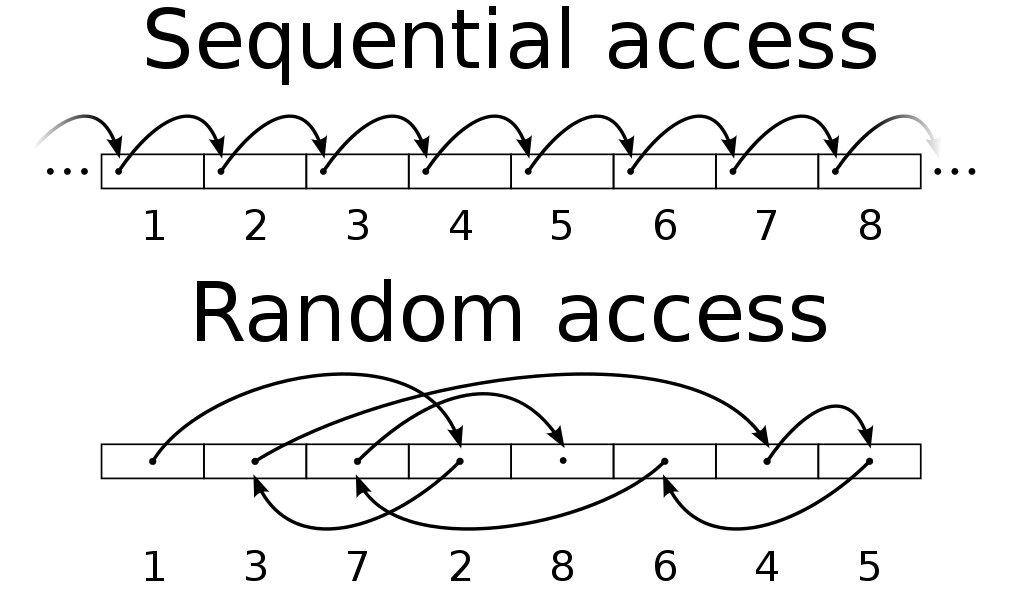
(Wikipedia, 2022)

- Sparse memory access
##### 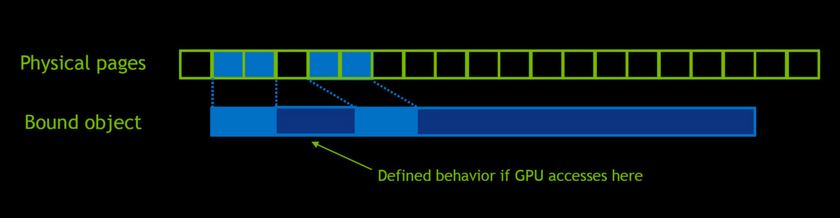
(Mujtaba, 2016)

- Misaligned memory access
##### 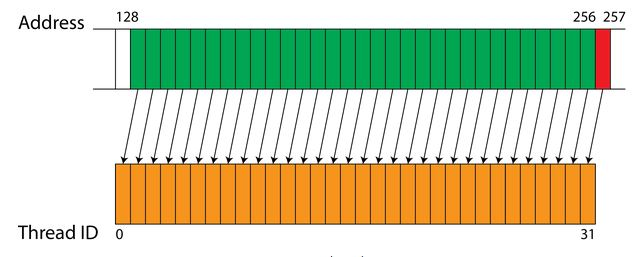
(cvw.cac.cornell.edu, n.d.)

Memory coalescing may also refer to the coalescing memory access patterns. Here the coalescing is used to prevent threads from non-simultaneous running and also to try access the nearby memory. This usually happens as:
- the memory is retrieved in a larger block from the RAM
- the possibility that the processing unit is trying to predict both future memory access and cache, while is still processing older parts of the memory.
- a slower but larger memory is cached in a hierarchy.


The above has high importance when a program is needed to be developed where the predictable memory patterns are important. When this planned program is a threaded one the predictability has the utmost importance as if the memory request is not simultaneous the processing unit most likely will be waiting for memory request to be filled (Computer Science Stack Exchange, n.d.).

Uniform memory access with four threads.
# 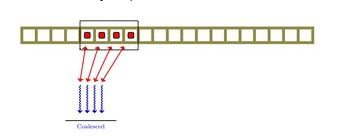

Above the memory accesses are close, therefore they can be retrieved with the least number of requests.

.

Increased "stride" between thread access.
# 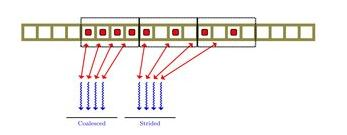

Above the streaded 4 threads will require two memory block request. We can see that smaller the stride the better, however if we compare a larger stread with random access it would be still more efficient (Computer Science Stack Exchange, n.d.).

======

## b) Define what is meant by a ‘race condition’ and what effects it can have upon computations.

By definition the race condition is where the program's behavior is dependent on multiple threads relative timing. We would refer to a program as thread safe when it is free from race conditions (baeldung, 2020). In the aspects of CUDA race condition would occur when threads attempt to read or write from the same memory location. Here there are two great hazards:
- Read-after-write hazard, where a memory location being read by a thread at the same time when it is written by another. 
- Write-after-write hazard, where the same memory location is to be written by two threads (John, 2020).



The impact of the race conditions may be referred as critical or noncritical.
- A critical race condition would change the end state of the system or program therefore would result in a bug, unpredicted or undefined behavior.
- A noncritical race condition would not directly change the end state, however may cause less time efficiency (Ben, 2021).


======

## c) Explain the benefits of using ‘CUDA atomic operations’ to mitigate the effects of race conditions and discuss the disadvantages / limitations of CUDA atomic operations.

The prevention of the race conditions' mentioned hazards at the previous point has a common strategy. One is to never use the same array for input and output, and another is to assign responsibility to each thread for a unique subset of the output array's elements. However often different threads will need to combine results and it is not guaranteed it is possible that numerous threads will change the global counter non-accordingly. Here is where CUDA steps in with the atomic operations, what would offer an invisible step to read, modify and update the memory locations in one (john, 2022).

The benefits of the atomic operations are:
- the mutual exclusion may be avoided
- they are relatively fast
- they are not suffering from deadlock or convoying (wwweic.eri.u-tokyo.ac.jp, n.d.).

The disadvantages of the atomic operations:
- the limited sets of operations
- the possibility of less efficient synthesizing of complicated operations (wwweic.eri.u-tokyo.ac.jp, n.d.).

-----------------------------------------------------------------------------

# 08. Functions & Memory Management

## a) Describe the main characteristics of NumPy universal functions.

- By date GPU hardware is designed to work with data parallelism. Those same operations that are processed on every element in Numpy array under the umbrella of NumPy Universal functions are naturally data parallel. Therefore, they are very well fit for GPU programming.
- The Numpy concept of ufuncs are functions with the capability to work on element-by-element in a NumPy array withing varying dimensions or scalars (John, 2022). 
- These also support array broadcasting, type casting and many other features. These vectorized wrappers would take in a fixed number of inputs and also would produce a fixed number of outputs.
- The ufuncs have many optional keyword arguments. 
- All unfuncs will return its output regardless of the use of optional output argument. However, the optiomal outputs can help save memory.
- The "and" and "or" keywords are avoidable and bitwise operators are recommended instead as "&" and "|" (numpy.org, n.d.).

======

## b) Explain with the aid of diagrams, how Numba compiles functions.

- The very first step is the Numba reads the Python bytecode as illustrated in the box with number 1.
- This will be combined with all relevant information as types, input arguments that are highlighted with number 2-s. 
- The bytecode analyzation shall start as the number 3 box. 
- The code optimizition will be done next highlighted with number 4-s.
- The boxes with number 5 are highlighting the use of LLVM complier library, where additional optimization and the generation of the machine code is being done.
- The box with number 6 is our ready to go machine code. The complied version of our code after this shall be use every time when the function is being called (numba.pydata.org, n.d.).
# 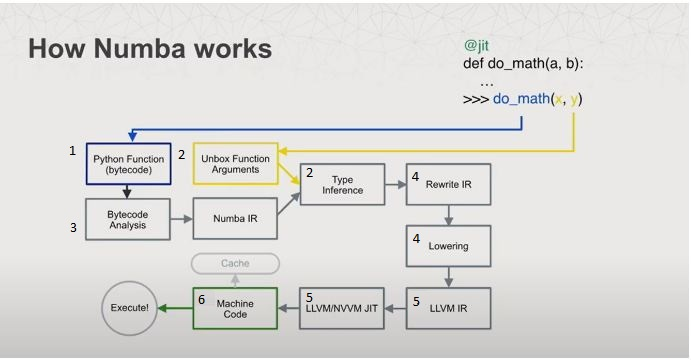
(news24-7live.com, n.d.)

## c) Cuda device arrays can be used to good effect to minimise the transfer of data between the host and device. Describe how this is achieved and support your answer with relevant code snippets.

- To minimize the data transfer we need to aim to determine whether the to run GPU or CPU version. The cost of data across the PCI-e bus is also need to be considered, especially at the initial porting code to CUDA (Mark, 2012).
- To avoid above we will need to prevent the automated data transfers between host and device. To achieve this CUDA Device Arrays needed to be created.
# 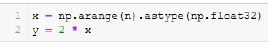
- Then will need to pass them to the GPU function with the "cuda.to_device(data to be sent to GPU).
# 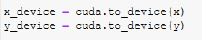
- An output array should be created that is "like" the input array, with cuda.device_array
# output array.JPG
- Here the device arrays shall not be transferred back automatically, therefore when it becomes necessary we will need to send them back either partially or fully with the appropriateArray.copy_to_host().
# 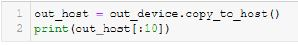
(John, 2022)


----

In [38]:
cuda.detect()

Found 1 CUDA devices
id 0            b'Tesla K80'                              [SUPPORTED]
                      compute capability: 3.7
                           pci device id: 4
                              pci bus id: 0
Summary:
	1/1 devices are supported


True

-----------------------------------------------------------------------------

# References:
- baeldung (2020). What is a Race Condition? | Baeldung on Computer Science. [online] www.baeldung.com. Available at: https://www.baeldung.com/cs/race-conditions.
- Ben, L. (2021). What is a Race Condition? [online] Available at: https://www.techtarget.com/searchstorage/definition/race-condition.
- Computer Science Stack Exchange. (n.d.). terminology - What is “memory coalescing”? [online] Available at: https://cs.stackexchange.com/questions/18229/what-is-memory-coalescing.
- cvw.cac.cornell.edu. (n.d.). Cornell Virtual Workshop: Memory Coalescing. [online] Available at: https://cvw.cac.cornell.edu/gpu/coalesced 
- GitHub. (2022). Numba Examples. [online] Available at: https://github.com/numba/numba-examples/blob/master/examples/density_estimation/histogram/gpu.py
- John, S (2022), Week 6: Parallel Programming using Numba and CUDA Python 1, student notes, High Performance Programming (2021/22), Letterkenny Institute of Technology, delivered 01 Jan 2022
- John, S (2022), Week 7: Parallel Programming using Numba and CUDA Python 2, student notes, High Performance Programming (2021/22), Letterkenny Institute of Technology, delivered 01 Feb 2022
- John, S (2022), Week 8: Parallel Programming using Numba and CUDA Python 3, student notes, High Performance Programming (2021/22), Letterkenny Institute of Technology, delivered 08 Feb 2022
- Mark, H. (2012).How to Optimize Data Transfers in CUDA C/C++. [online] Available at: https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/
- Mujtaba, H. (2016). NVIDIA Launches Special Vulkan Drivers For GeForce Graphics Cards - Kepler and Maxwell Fully Supported on Windows / Linux. [online] Wccftech. Available at: https://wccftech.com/nvidia-geforce-vulkan-drivers-launch/
- news24-7live.com. (n.d.). Make Python Code Faster With Numba – News 24-7 Live. [online] Available at: https://news24-7live.com/make-python-code-faster-with-numba/ 
- Robert C. (n.d.). Synchronization in CUDA. [online] Available at: https://stackoverflow.com/questions/15935515/synchronization-in-cuda 
- numba.pydata.org. (n.d.). A ~5 minute guide to Numba — Numba 0.50.1 documentation. [online] Available at: https://numba.pydata.org/numba-doc/latest/user/5minguide.html
- numpy.org. (n.d.). Universal functions (ufunc) — NumPy v1.22 Manual. [online] Available at: https://numpy.org/doc/stable/reference
- Wikipedia. (2022). Sequential access. [online] Available at: https://en.wikipedia.org/wiki/Sequential_access#/media
- wwweic.eri.u-tokyo.ac.jp. (n.d.). Atomic Operations. [online] Available at: http://wwweic.eri.u-tokyo.ac.jp/computer/manual/eic2015/doc/intel/en_US/tbb/tbb_ugref/tbb_userguide/Atomic_Operations.htm
